# G-Learn

 G-Learn is a python package that utilizes **G**aussian process for machine **learn**ing.
 
### Features
 
 G-Learn is fast, since:
 * It can take advantage of parallelization on both CPU and CUDA-capable multi-GPU devices.
 * It trains model using novel method that is shown to be up to a thousand times faster than the conventional training methods.
 
This interactive tutorial demonstrates a somplistic usage of [glearn](https://ameli.github.io/glearn/index.html) package.

### Tutorials

See a 1-minute minimalistic tutorial here.
 
 ### Installation
 
 Install ``glearn`` either from [PyPI](https://pypi.org/project/glearn/) by:
 
    pip install glearn
     
or from [Anaconda](https://anaconda.org/s-ameli/glearn) by:

    conda install -c s-ameli glearn 
    
### Import
     
Import the package using:

In [1]:
import glearn

Before starting, you may check the version of G-Learn, avaialble number of CPU processors, GPU devices, and memory usage of the current python process via:

In [2]:
glearn.info()


glearn version  : 0.14.3
imate version   : 0.10.4
processor       : Intel(R) Core(TM) i7-4770K CPU @ 3.50GHz
num threads     : 8
gpu device      : none
num gpu devices : 0
cuda version    : 11.5.1
process memory  : 110.8 (Mb)



### Generate Points

We generate a set of 50 points randomly distributed in the interval $ \mathcal{D} = [0, 1]$, where $r=80\%$ of the points are concentrated in the sub-interval $[a=0.4, b=0.6]$ with uniform distrubution, and the rest of the points spread elsewhere uniformly.

For simplicity,such set of points can be screated using ``glearn.sample_data`` module.

In [3]:
# For reproducibility, fix the seed of the random number genrator
import numpy
numpy.random.seed(0)

# Using sample_data module to generate random points
from glearn import sample_data

# Define sub-interval [0.4, 0.6] with cincentrated 80% of the points
points = sample_data.generate_points(
    num_points=50, dimension=1, a=0.4, b=0.6, ratio=0.8, grid=False)

### Generate Noisy Data

On the set of points $\boldsymbol{x} \in \mathcal{D} \in \mathbb{R}^d$ (here $d=1$) defined in the above, we define a stochastic function:

$$z(x) = \sin\left(\pi x \right) + \epsilon,$$

where $\epsilon$ is a random variable $\epsilon(x) \sim \mathcal{N}(0, \sigma_0^2)$ with the noise standard deviation $\sigma_0 = 0.05$. 

The above random data can be generated by ``glearn.sample_data`` module.

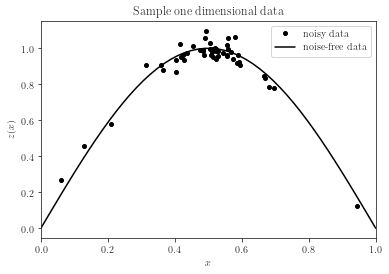

In [4]:
from glearn import sample_data
z_noisy = sample_data.generate_data(points, noise_magnitude=0.05, plot=True)

The above figure shows the noisy data (dots) and the original function without noise (solid curve). We remind that most of the data points are concentrated in the sub-interval $[0.4, 0.6]$, whereas outside this interval, we have sparse data. We wil later demonstrate a good prediction in the concentrated sub-interval and less accurate prediction outside.

### Stochastic Model for Noisy Data

We model the random data $z$ by

$$z(x) = \mu(x) + \delta(x) + \epsilon(x),$$

where

* $\mu(x)$ is a deterministic mean function.
* $\delta(x)$ is a zero-mean stochastic function and will be determined later.
* $\epsilon(x)$ is a zero-mean stochastic function representing the input noise and characterized by the discrete covariance:

    $$\mathbb{E}[\epsilon(x), \epsilon(x')] = \sigma_0^2 \mathbf{I}$$
    
  where $\mathbf{I}$ is the identity matrix, and the hyperparameter $\sigma_0^2$ is the variance of the noise. We assume the noise variance is not known.

### Design Matrix

We represent the deterministic mean function $\mu$ by the linear model $\mu(\boldsymbol{x}) = \boldsymbol{\phi}(x)^{\intercal} \cdot \boldsymbol{\beta}$  as a linear combination of basis functions:

$$\boldsymbol{\phi}(x): \mathcal{D} \to \mathbb{R}^m,$$

and $\beta \in \mathbb{R}^{m}$ are the parameters. On discrete points $\boldsymbol{x}$, the set of basis functions are disretized to the design matrix $\mathbf{X} \in \mathbf{R}^{n \times m}$

$$X_{ij} = \phi_{j}(\boldsymbol{x}_i)$$

Other ways to contrust the design matrix are by trogonometric functions, hyperbolic functions, user-defined custom functions, or a combination of all. Here we only use a fifth order monomial as follows:

$$\boldsymbol{\phi}(\boldsymbol{x}) = (1, x, \cdots, x^4)^{\intercal}.$$

Hence, $m = 5$.

In [5]:
# Configuring the design matrix, X
polynomial_degree = 5
trigonometric_coeff = None
hyperbolic_coeff = None

### Prior for Parameter $\boldsymbol{\beta}$

We also prescibe a normal prior to the unknown parameter $\boldsymbol{\beta}$:

$$p(\boldsymbol{\beta} | \sigma^2) \sim \mathcal{N}(\boldsymbol{b}, \sigma^2 \mathbf{B}),$$

where $\sigma^2  \mathbf{B} \in \mathbb{R}^{m \times m}$ is the covariance of $\boldsymbol{\beta}$. The hyperparameter $\sigma^2$ is the variance of the regression and is not known.

In [6]:
# Mean of hyperparameter beta.
# The size of b should be m, the number of columns of design matrix X.
b = numpy.zeros((6, ))

# Generate a random matrix B for covariance of beta.
# The shape of matrix B should be (m, m)
B = numpy.random.rand(b.size, b.size)

# Making sure the covariance matrix B positive-semidefinite
B = 1e+5 * B.T @ B

### Linear Model

The linear model of mean $\mu = \mathbf{X} \boldsymbol{\beta}$ can be created by ``glearn.mean.LinearModel`` class:

In [7]:
# Create mean object using glearn.
mean = glearn.mean.LinearModel(points, polynomial_degree=5, b=b, B=B)

### Kernels

The zero-mean stochastic function $\delta(x): \mathcal{D} \to \mathbb{R}$ is characterized by its covariance,

$$\mathbb{E}[\delta(x), \delta(x')] = k(x, x'|\boldsymbol{\theta}).$$

The function $k: \mathcal{D} \times \mathcal{D} \times \mathbb{R}^d \to \mathbb{R}$ is the correlation kernel and can be created by ``glearn.kernel`` module. Various kernels of this module are

* ``Matern()``
* ``Exponential()``
* ``SquareExponential()``
* ``RationalQuadratic()``

Here we use the exponential kernel.

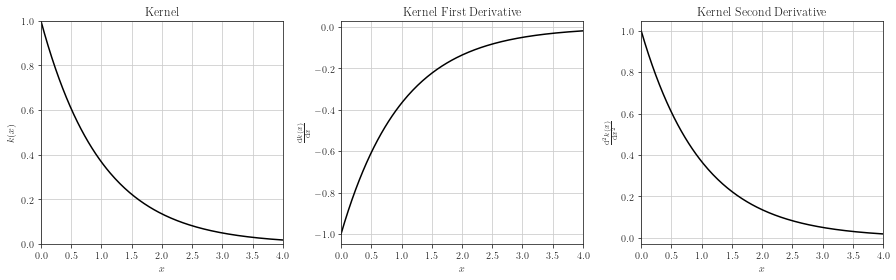

In [8]:
from glearn import kernels
kernel = kernels.Exponential()
kernel.plot()

### Scale Hyperparameter

The hyperparameters $\boldsymbol{\theta} = (\theta_1, \dots, \theta_d) \in \mathbb{R}^d$ determines the scale of each spatial dimension. In our example, $d=1$. Scale can be either explicity given if known, or can be charactewrized by a prior distribution $p(\boldsymbol{\theta})$ using ``glearn.priors`` class. A list of available priors are

* ``Uniform``
* ``Cauchy``
* ``StudentT``
* ``InverseGamma``
* ``Normal``
* ``Erlang``
* ``BetaPrime``

Here, we use Cauchy prior. We also plot the prior and its frist and second derivative.

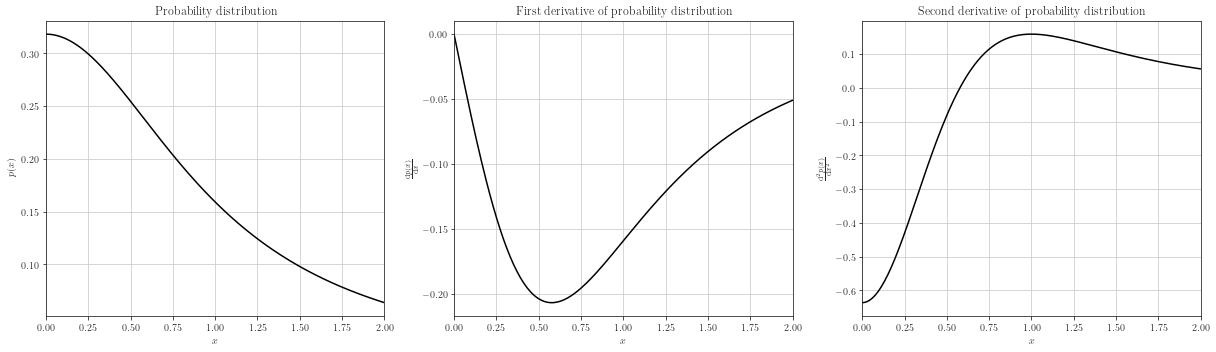

In [9]:
from glearn import priors
scale = priors.Cauchy()
scale.plot()

### Correlation

Based on the kernel, the correlation matrix:

$$\mathbf{K}(\boldsymbol{\theta}): \mathbb{R}^{d} \to \mathbb{R}^{n \times n},$$

is created. The correlation object representing $\mathbf{K}(\boldsymbol{\theta})$ is created by ``glearn.corelation`` class.

In [10]:
cor = glearn.Correlation(points, kernel=kernel, scale=scale, sparse=False)

### Covariance

The covariance of the model is

$$\boldsymbol{\Sigma}(\sigma^2, \sigma_0^2, \boldsymbol{\theta}) = \sigma^2 \mathbf{K}(\boldsymbol{\theta}) + \sigma_0^2 \mathbf{I}.$$

An object of the above covariance model can be created by ``glearn.Covariance`` class. The internal matrix algebra of this object can be set via ``imate_method`` argument, which can take value from one of the followings:

* ``eigenvalue``: using eigenvalue method.
* ``cholesky``: using Cholesky method.
* ``hutchinson``: using stochastic Hotchinson method.
* ``slq``: using stochastic Lanczos quadrature method.

Here we use the Cholesky method.

In [11]:
imate_method = 'cholesky'
cov = glearn.Covariance(cor, imate_method=imate_method)

### Gaussian Proces

The Gaussian process

$$z \sim \mathcal{GP}(\mu, \boldsymbol{\Sigma})$$

is then created by ``glearn.GaussianProcess`` class using the mean and covariance objects.

In [12]:
gp = glearn.GaussianProcess(mean, cov)

### Training Hyperparameters

The hyperparameters $(\sigma, \sigma_0, \boldsymbol{\theta})$ and the parameter $\boldsymbol{\beta}$ can be trained via ``gp.train()`` function.

The type of profiling for the likelihood function can be set by ``profile_hyperparam`` argument, which can take one of the following values:

* ``'none``: no prifiling
* ``'var'``: profiling on variance hyperparameter.
* ``'var_noise'``: profiling on both variance and noise hypeprarameter.

The optimization method can be set by ``optimization_method`` and can be one of:

* ``'chandrupatla'``: requires jacobian
* ``'brentq'``: requires jacobian
* ``'Nelder-Mead'``: requires func
* ``'BFGS'``: requires func, jacobian
* ``'CG'``: requires func, jacobian
* ``'Newton-CG'``: requires func, jacobian, hessian
* ``'dogleg'``: requires func, jacobian, hessian
* ``'trust-exact'``: requires func, jacobian, hessian
* ``'trust-ncg'``: requires func, jacobian, hessian

In [13]:
profile_hyperparam = 'var'
optimization_method = 'Newton-CG'
hyperparam_guess = None
result = gp.train(z_noisy, profile_hyperparam=profile_hyperparam,
                  log_hyperparam=True, hyperparam_guess=hyperparam_guess,
                  optimization_method=optimization_method, tol=1e-6,
                  max_iter=1000, use_rel_error=True,
                  verbose=True, plot=False)


       Convergence       
itr   param  1   param  2
---   --------   --------
001        inf        inf
002   3.94e-01   8.38e-01
003   2.33e-01   1.11e-01
004   5.27e-02   1.03e-01
005   1.45e-04   2.69e-03
006   3.85e-07   2.15e-06

                                Training Summary                                
       posterior/param                optimization              imate solver    
-----------------------------      -------------------      --------------------
posterior    +6.662938365e+01      method    Newton-CG      method      cholesky
eta          6.7941836122e-01      tol        1.00e-06      tol         1.00e-08
sigma        4.7276467171e-02      max iter       1000      interpolate    False
sigma0       3.8968496977e-02      max bracket try   6      min num samples    0
theta        4.9625412310e-01      profile param   var      max num samples    0

                                    Process                                     
         time (sec)               

### Prediction

After training the hyperparameters, the ``gp`` object is ready to predict the data on new points. First, we greate a set of test points $x^{\star}$ equally distanced in the interval $[0, 1]$.

In [14]:
# Generate test points
test_points = sample_data.generate_points(num_points=1000, dimension=1, grid=True)

For sake of compaison, we also generate the noise-free data on the test points, $z(x^{\star})$, using zero noise $\sigma_0 = 0$.

In [15]:
# True data without noise
z_true = sample_data.generate_data(test_points, noise_magnitude=0.0)

Note that the above step is unneccessary and only used for the purpose of comparson with the prediction since we already know the exact function that generated the noisy data $z$ ikn the first place.

The posterior predictive distribution of the predicton $z^{\star}(x^{\star})$ is of the form

$$z^{\star}(x^{\star}) \sim \mathcal{N}\left(\mu^{\star}(x^{\star}), \mathbf{\Sigma}^{\star \star}(x^{\star}, x'^{\star})\right)$$

where:

* $\mu^{\star}$ is the posterior predictive mean, and
* $\mathbf{\Sigma}^{\star \star}$ is the posterior predictive covariance between test points and themselves.

Prediction can be made using ``gp.predict()`` function. 


                               Prediction Summary                               
               process                                    config                
-------------------------------------      -------------------------------------
wall time (sec)               1.73e-1      num training points                50
proc time (sec)               1.25e+0      num test points                  1000
memory used (Mb)                   22      compute covariance               True



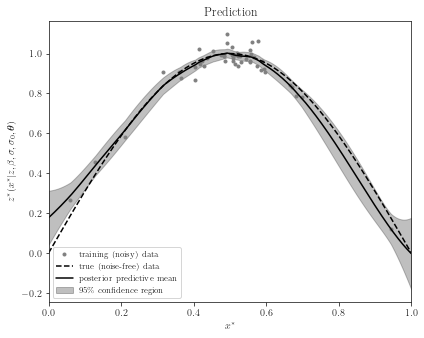

In [16]:
z_star_mean, z_star_cov = gp.predict(test_points, cov=True, plot=True,
                                     confidence_level=0.95,
                                     true_data=z_true, verbose=True)

By seeting boolean argument ``cov=False`` the predictive covariance is not computed, which enhances the computaional speed.

* When ``cov=True``, meaning that both $\mu^{\star}$ and $\mathbf{\Sigma}^{\star \star}$ are computed, the prediction process is $\mathcal{O}\left((n^{\star})^3\right)$ complex.
* In contrast, when ``cov=False`` to only compute $\mu^{\star}$, the prediction process is only $\mathcal{O}\left((n^{\star})^2\right)$ complex. 

Furthermore, when ``cov=False``, once the first prediciton on a set of test points $\left\{ x_i^{\star} \right\}_{n^{\star}}$ is made, the future calls to the ``predict()`` function is of order $\mathcal{O}(n^{\star})$, *even when applied on a different set of test points*. This is becase the ``gp`` object stores all internal computations that are independent of the test points.

In [17]:
z_star_mean = gp.predict(test_points, cov=False, verbose=True)


                               Prediction Summary                               
               process                                    config                
-------------------------------------      -------------------------------------
wall time (sec)               2.38e-2      num training points                50
proc time (sec)               1.18e-1      num test points                  1000
memory used (b)                     0      compute covariance              False

